Weekly Tasks 2
Model the data to find the price based on the input features.



In [1]:
# Install required libraries
%pip install pandas numpy matplotlib seaborn scikit-learn wordcloud

Note: you may need to restart the kernel to use updated packages.


In [2]:
#Import required libraries
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing
from collections import Counter

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

##### Load and Clean Data
In this section, we will load the dataset from a CSV file and clean it.
The cleaning process includes handling currency and area values,
converting relevant columns to numeric types, and renaming columns
to include units. We'll then display a summary of the cleaned dataset.


In [3]:
# Load the dataset
def load_data(file_path):
    """
    Load dataset from a CSV file.
    """
    try:
        data = pd.read_csv(file_path)
        print("Dataset loaded successfully.")
        return data
    except FileNotFoundError:
        print(f"File not found at {file_path}.")
        return None

# Clean the dataset
def clean_data(df):
    """
    Clean and preprocess the DataFrame.
    """
    # Function to clean currency and area columns
    def clean_value(val):
        if isinstance(val, str):
            val = val.replace('$', '').replace(',', '').replace('Contact For Price', '').strip()
            if val.endswith('/mo'):
                val = val[:-3]  # Remove '/mo'
            if val.endswith('sqft'):
                val = val[:-4]  # Remove 'sqft'
            if val.endswith('+'):
                val = val[:-1]  # Remove the '+' sign
            try:
                return float(val) if val else val
            except ValueError:
                return val
        return val

    # List of columns to clean
    cols_to_clean = ['Price', 'Sqr Ft', 'Price Sqr Ft', 'Lot Size', 'Last Sold For']

    for col in cols_to_clean:
        df[col] = df[col].apply(clean_value)

    # Convert relevant columns to numeric, keeping original values if conversion fails
    numeric_cols = ['Beds', 'Bath', 'Year Built', 'Zipcode']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col] = df[col].fillna(df[col].astype(object))

    # Update column names with units
    df = df.rename(columns={
        'Price': 'Price ($)',
        'Sqr Ft': 'Sqr Ft (sqft)',
        'Lot Size': 'Lot Size (sqft)',
        'Price Sqr Ft': 'Price Sqr Ft ($/sqft)',
        'Last Sold For': 'Last Sold For ($)'
    })

    return df

# Load and clean the data
file_path = 'houseprice.csv'
df = load_data(file_path)
if df is not None:
    df = clean_data(df)
    print("Data cleaning completed.")
    print("\nSummary of the cleaned dataset:")
    print(df.describe().round(2).to_string())
    
    print("\nFirst five rows of the cleaned dataset:")
    print(df.head().to_string(index=False))
    
    print("\nDataset information:")
    df.info()
    
    # Save the cleaned data to a CSV file
    cleaned_file_path = 'cleaned_data.csv'
    df.to_csv(cleaned_file_path, index=False)
    print(f"\nCleaned data saved to {cleaned_file_path}")
else:
    # Handle the case where data couldn't be loaded
    df = pd.DataFrame()

Dataset loaded successfully.
Data cleaning completed.

Summary of the cleaned dataset:
       Sqr Ft (sqft)  Longitude  Latitude      Beds      Bath  Year Built  Last Sold Year  Last Sold For ($)   Zipcode
count       27786.00   30006.00  30006.00  27420.00  27496.00    26258.00        14213.00       1.421300e+04  30003.00
mean         5082.98     -95.17     36.16      3.29      2.58     1973.14         2011.11       3.469467e+05  59349.27
std        248479.13      15.45      5.50      1.47      1.45       34.51            6.60       1.187349e+06  27206.13
min             1.00    -150.05     25.55      1.00      0.75     1800.00         1987.00       1.000000e+00   2108.00
25%          1286.00    -106.74     32.75      3.00      2.00     1950.00         2006.00       1.130000e+05  33137.00
50%          1800.00     -93.39     36.02      3.00      2.00     1978.00         2013.00       2.098000e+05  68124.00
75%          2544.00     -81.64     40.02      4.00      3.00     2004.00       

C:\Users\22837352\AppData\Local\Temp\ipykernel_19152\309409784.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(df[col].astype(object))
C:\Users\22837352\AppData\Local\Temp\ipykernel_19152\309409784.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(df[col].astype(object))
C:\Users\22837352\AppData\Local\Temp\ipykernel_19152\309409784.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=Fals


Cleaned data saved to cleaned_data.csv


##### Basic Exploratory Data Analysis (EDA)
In this section, we will perform an in-depth Exploratory Data Analysis (EDA) on the cleaned dataset:
1. Data Cleaning and Preparation:
   - Convert 'Price ($)' to numeric, handling special cases
   - Clean and standardize 'Lot Size (sqft)' data
   - Ensure all numeric features are properly formatted
   - Apply log transformation to 'Price ($)' for better distribution analysis
2. Univariate Analysis:
   - Visualize the distribution of log-transformed house prices using a histogram
   - Examine distributions of other key numeric features
3. Bivariate Analysis:
   - Create a correlation matrix heatmap to show relationships between numeric features
   - Generate scatter plots for key features vs. Log Price
4. Categorical Variable Analysis:
   - Analyze high cardinality features like 'City' and 'State' by plotting average prices
5. Data Quality Checks:
   - Implement column existence checks to ensure data integrity
   - Handle missing values and potential data inconsistencies
6. Advanced Visualizations:
   - Utilize seaborn for enhanced statistical graphics
   - Create multi-plot figures for comprehensive feature comparisons
7. Performance Considerations:
   - Implement efficient data handling for large datasets
   - Utilize appropriate plot sizes and layouts for clear visualizations


In [11]:
# Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Exploratory Data Analysis Class
class ExploratoryDataAnalysis:
    def __init__(self, df):
        """
        Initialize the EDA with a DataFrame.

        Parameters:
        df (pd.DataFrame): The DataFrame to perform EDA on.
        """
        self.df = df.copy()
        self.numeric_features = ['Sqr Ft (sqft)', 'Beds', 'Bath', 'Lot Size (sqft)', 'Year Built']
        self.high_cardinality_cols = ['Price Sqr Ft ($/sqft)', 'Address', 'City', 'State', 'Address Full']
        self.output_folder = r"G:\Uni\2nd year\Intro to AI\Regression\assignment-1-ryantigi254\Regression\Weekly Tasks\Visualisation Outputs"
        os.makedirs(self.output_folder, exist_ok=True)

    def check_column_exists(self, column_name):
        """
        Check if a column exists in the DataFrame.

        Parameters:
        column_name (str): The name of the column to check.

        Returns:
        bool: True if the column exists, False otherwise.
        """
        if column_name not in self.df.columns:
            print(f"Error: '{column_name}' column not found in the dataframe.")
            return False
        return True

    def clean_data(self):
        """
        Clean the DataFrame for analysis.

        - Convert 'Price ($)' to numeric, handling 'Contact For Estimate'.
        - Convert 'Lot Size (sqft)' from acres to sqft if necessary.
        - Ensure all numeric features are converted to numeric data types.
        """
        # Clean 'Price ($)' column
        self.clean_price_column()

        # Clean 'Lot Size (sqft)' column
        self.clean_lot_size_column()

        # Convert numeric features to appropriate data types
        self.convert_numeric_features()

        # Log transform 'Price ($)'
        if self.check_column_exists('Price ($)'):
            self.df['Log Price ($)'] = np.log1p(self.df['Price ($)'])

    def clean_price_column(self):
        """Convert 'Price ($)' to numeric, handling special cases."""
        if self.check_column_exists('Price ($)'):
            self.df['Price ($)'] = self.df['Price ($)'].replace('Contact For Estimate', np.nan)
            self.df['Price ($)'] = pd.to_numeric(self.df['Price ($)'], errors='coerce')

    def clean_lot_size_column(self):
        """Clean and convert 'Lot Size (sqft)' to numeric values in sqft."""
        if self.check_column_exists('Lot Size (sqft)'):
            # Apply conversion to each value in 'Lot Size (sqft)'
            self.df['Lot Size (sqft)'] = self.df['Lot Size (sqft)'].apply(self.convert_lot_size)
            # Convert the cleaned values to numeric
            self.df['Lot Size (sqft)'] = pd.to_numeric(self.df['Lot Size (sqft)'], errors='coerce')

    def convert_numeric_features(self):
        """Ensure all specified numeric features are converted to numeric data types."""
        for feature in self.numeric_features:
            if self.check_column_exists(feature):
                self.df[feature] = pd.to_numeric(self.df[feature], errors='coerce')

    @staticmethod
    def convert_lot_size(value):
        """
        Convert 'Lot Size (sqft)' from acres to sqft if applicable.

        Parameters:
        value: The value to convert.

        Returns:
        float: The converted lot size in sqft, or NaN if conversion fails.
        """
        try:
            if pd.isna(value):
                return np.nan
            value_str = str(value).strip().lower()
            if 'acres' in value_str:
                # Extract the numeric part and convert acres to sqft
                number = float(value_str.replace('acres', '').strip())
                return number * 43560
            else:
                # Remove commas and convert to float
                return float(value_str.replace(',', ''))
        except (ValueError, TypeError):
            return np.nan

    def plot_distribution(self, column_name, title, xlabel):
        """
        Plot the distribution of a given numeric column.

        Parameters:
        column_name (str): The name of the column to plot.
        title (str): The title of the plot.
        xlabel (str): The label for the x-axis.
        """
        if self.check_column_exists(column_name):
            plt.figure(figsize=(10, 6))
            sns.histplot(self.df[column_name].dropna(), bins=50, kde=True)
            plt.title(title)
            plt.xlabel(xlabel)
            plt.ylabel('Frequency')
            plt.tight_layout()
            plt.savefig(os.path.join(self.output_folder, f"{title.replace(' ', '_')}.png"))
            plt.close()

    def plot_correlation_matrix(self):
        """
        Plot the correlation matrix for numeric features.
        """
        numeric_cols = self.df.select_dtypes(include=[np.number]).columns
        numeric_cols = [col for col in numeric_cols if col != 'Price ($)']
        if numeric_cols:
            plt.figure(figsize=(12, 10))
            corr_matrix = self.df[numeric_cols].corr()
            sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
            plt.title('Correlation Matrix')
            plt.tight_layout()
            plt.savefig(os.path.join(self.output_folder, "Correlation_Matrix.png"))
            plt.close()

    def plot_scatter_plots(self):
        """
        Generate scatter plots for each numeric feature against Log Price.
        """
        if self.check_column_exists('Log Price ($)'):
            valid_features = [feature for feature in self.numeric_features if self.check_column_exists(feature)]
            num_plots = len(valid_features)
            rows = (num_plots + 1) // 2
            fig, axes = plt.subplots(rows, 2, figsize=(15, 5 * rows))
            axes = axes.flatten()
            for idx, feature in enumerate(valid_features):
                sns.scatterplot(
                    data=self.df,
                    x=feature,
                    y='Log Price ($)',
                    ax=axes[idx]
                )
                axes[idx].set_title(f'{feature} vs. Log Price')
                axes[idx].set_xlabel(feature)
                axes[idx].set_ylabel('Log Price ($)')
            # Remove any unused subplots
            for idx in range(num_plots, len(axes)):
                fig.delaxes(axes[idx])
            plt.tight_layout()
            plt.savefig(os.path.join(self.output_folder, "Scatter_Plots.png"))
            plt.close()

    def handle_high_cardinality_features(self):
        """
        Visualize high cardinality features like 'City' and 'State' by plotting average prices.
        """
        for col in self.high_cardinality_cols:
            if self.check_column_exists(col):
                if col in ['State', 'City']:
                    plt.figure(figsize=(12, 6))
                    avg_price = self.df.groupby(col)['Price ($)'].mean().nlargest(20)
                    avg_price.plot(kind='bar')
                    plt.title(f'Average House Price by {col}')
                    plt.xlabel(col)
                    plt.ylabel('Average Price ($)')
                    plt.tight_layout()
                    plt.savefig(os.path.join(self.output_folder, f"Average_Price_by_{col}.png"))
                    plt.close()

    def perform_eda(self):
        """
        Execute the complete EDA process:
        - Clean data
        - Plot distributions
        - Plot correlation matrix
        - Plot scatter plots
        - Handle high cardinality features
        """
        print("Starting EDA...")
        self.clean_data()
        print("Data cleaned successfully.")

        # Plot distributions
        self.plot_distribution('Log Price ($)', 'Log-Transformed Distribution of House Prices', 'Log Price ($)')

        # Plot correlation matrix
        self.plot_correlation_matrix()

        # Plot scatter plots
        self.plot_scatter_plots()

        # Handle high cardinality features
        self.handle_high_cardinality_features()
        print("EDA completed successfully.")

# Main execution
def main():
    file_path = r"G:\Uni\2nd year\Intro to AI\Regression\assignment-1-ryantigi254\Regression\Weekly Tasks\cleaned_data.csv"

    if not os.path.exists(file_path):
        print(f"Error: The file '{file_path}' does not exist.")
    else:
        try:
            df = pd.read_csv(file_path)
            if df.empty:
                print("Error: The dataframe is empty. Unable to perform EDA.")
            else:
                print(f"Data loaded successfully. Shape: {df.shape}")
                eda = ExploratoryDataAnalysis(df)
                eda.perform_eda()
        except Exception as e:
            print(f"An error occurred during EDA: {str(e)}")

if __name__ == "__main__":
    main()



Data loaded successfully. Shape: (30006, 16)
Starting EDA...
Data cleaned successfully.
EDA completed successfully.


##### Advanced Exploratory Data Analysis (EDA)
In this section, we will perform an advanced Exploratory Data Analysis (EDA) on the cleaned dataset:

1. Data Preparation and Cleaning:
   - Initialize the EDA class with the dataset and define key feature categories
   - Implement robust data cleaning methods for 'Price ($)' and 'Lot Size (sqft)'
   - Convert all numeric features to appropriate data types
   - Apply log transformation to 'Price ($)' for improved analysis

2. Categorical Variable Analysis:
   - Generate box plots for top categories in categorical variables
   - Visualize price distributions across different categorical features

3. Price per Square Foot Analysis:
   - Clean and transform 'Price Sqr Ft ($/sqft)' data
   - Handle outliers by capping at the 95th percentile
   - Create histograms for both original and log-transformed price per square foot

4. Text Data Visualization:
   - Generate word clouds for 'Address' and 'Address Full' columns if WordCloud is available
   - Alternatively, plot top 20 most common words in these columns

5. Advanced Visualization Techniques:
   - Utilize seaborn for enhanced statistical graphics
   - Implement multi-plot figures for comprehensive feature comparisons

6. Data Integrity and Error Handling:
   - Implement column existence checks to ensure data integrity
   - Handle missing values and potential data inconsistencies
   - Incorporate robust error handling and informative error messages

7. Performance and Scalability:
   - Implement efficient data handling techniques for large datasets
   - Utilize appropriate plot sizes and layouts for clear visualizations

8. Output Management:
   - Save all generated plots in a dedicated output folder
   - Provide informative console outputs for tracking the EDA process

This advanced EDA aims to provide a comprehensive understanding of the dataset, uncovering key insights and patterns in the housing market data.



Data loaded successfully. Shape: (30006, 16)
Starting EDA...
Cleaning data...
Data cleaned successfully.
Plotting box plots for categorical variables...


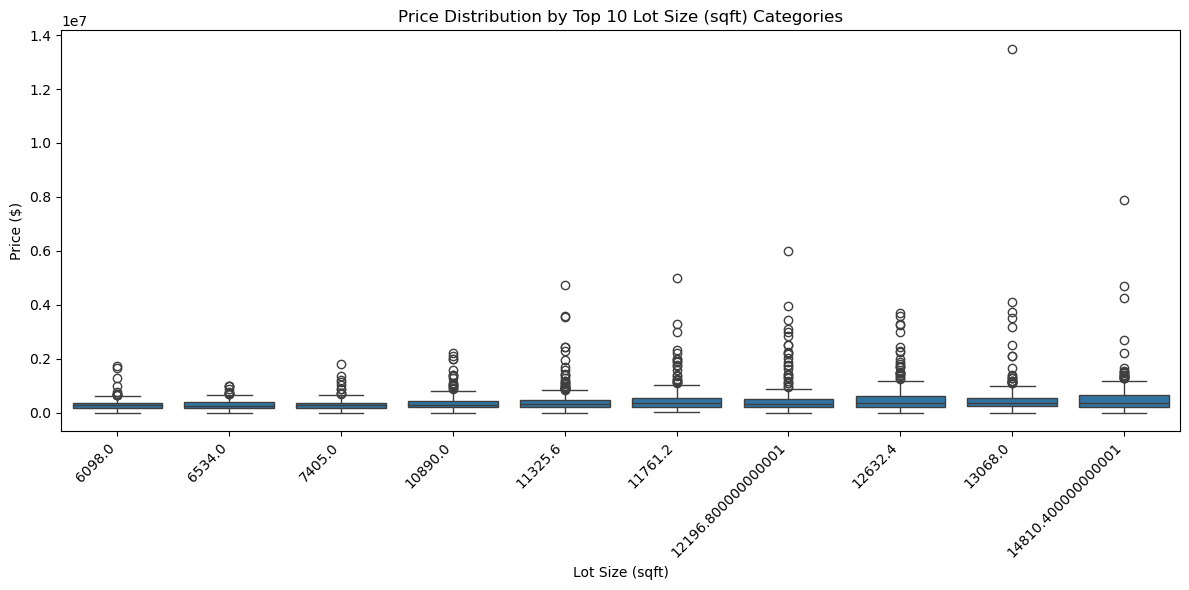

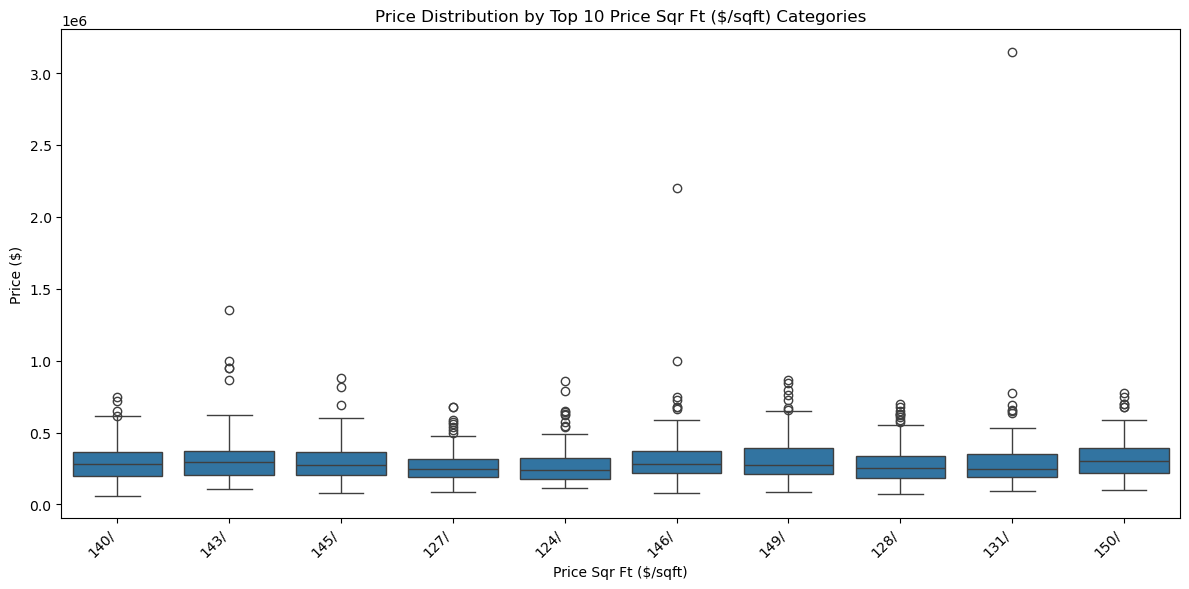

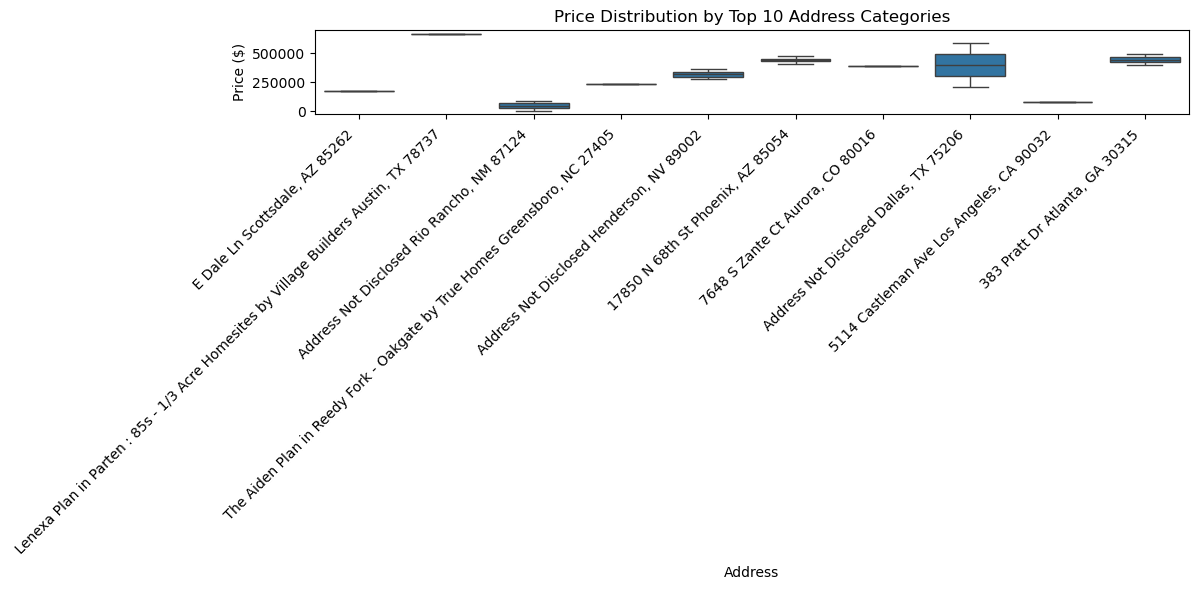

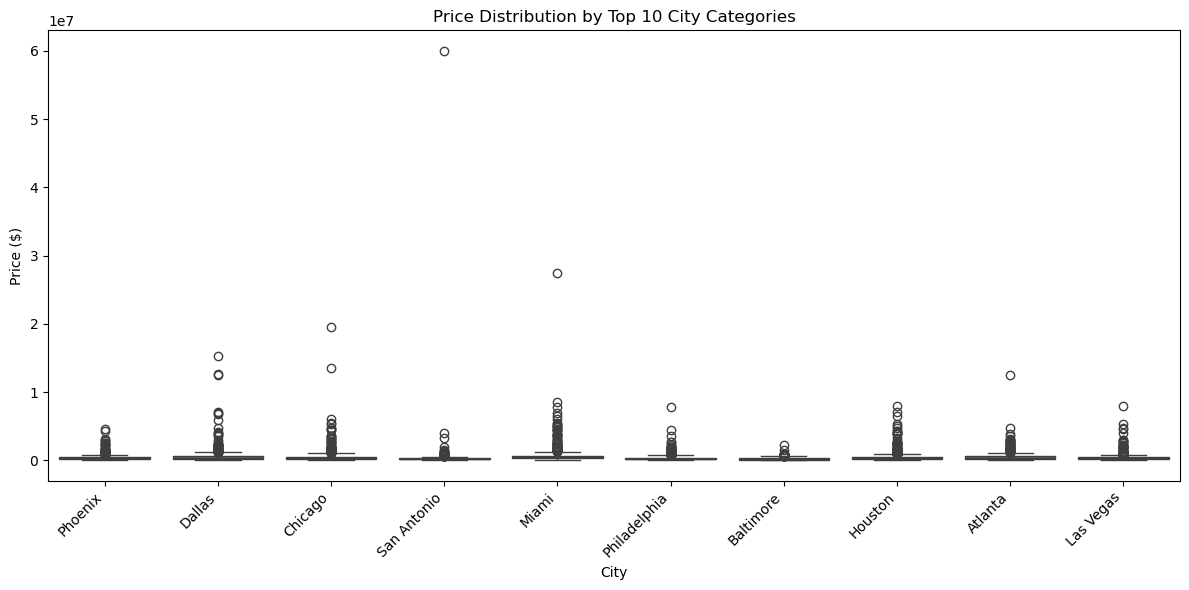

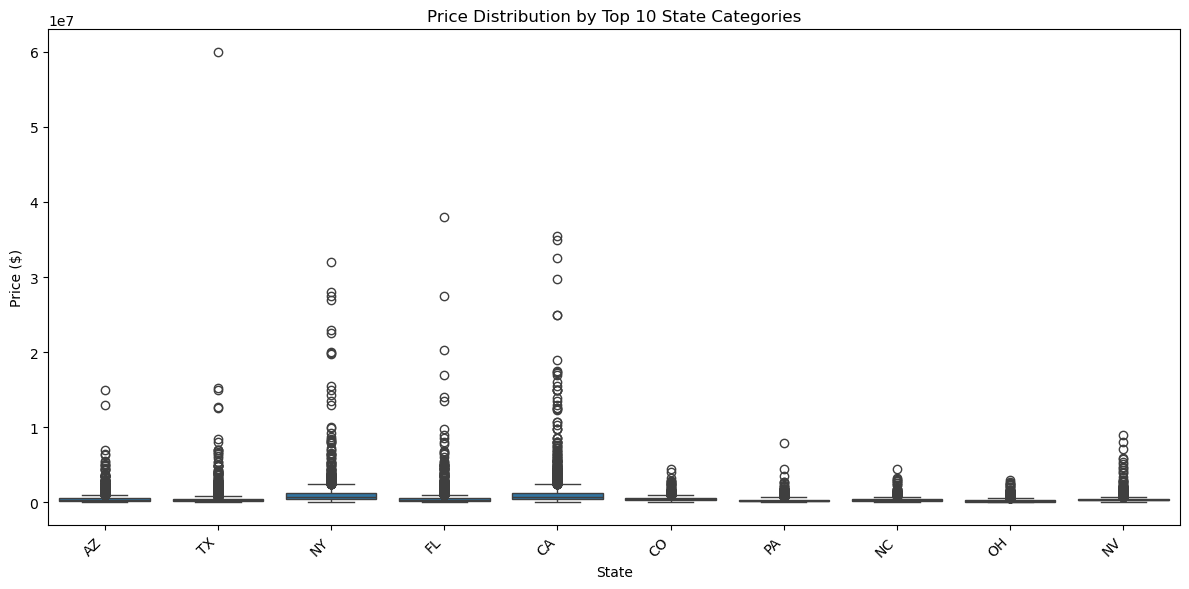

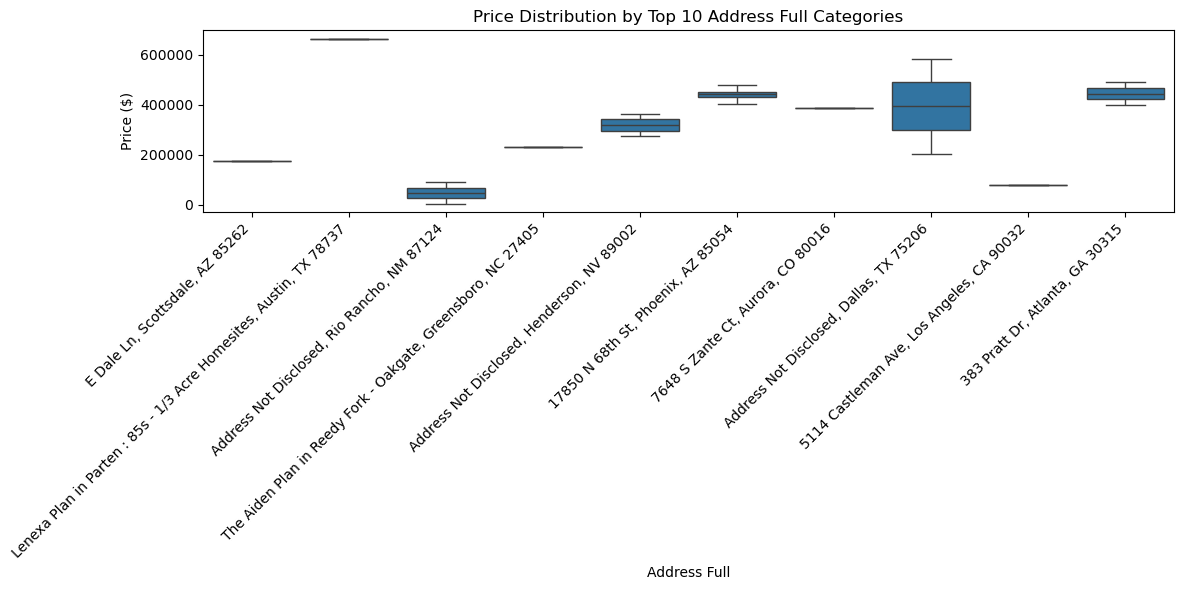

Handling 'Price Sqr Ft ($/sqft)'...


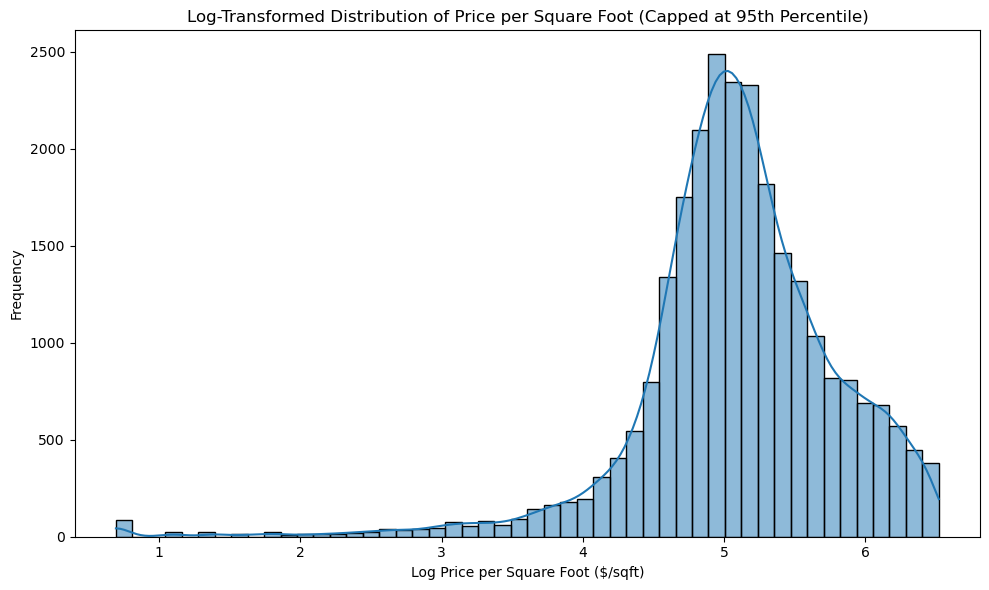

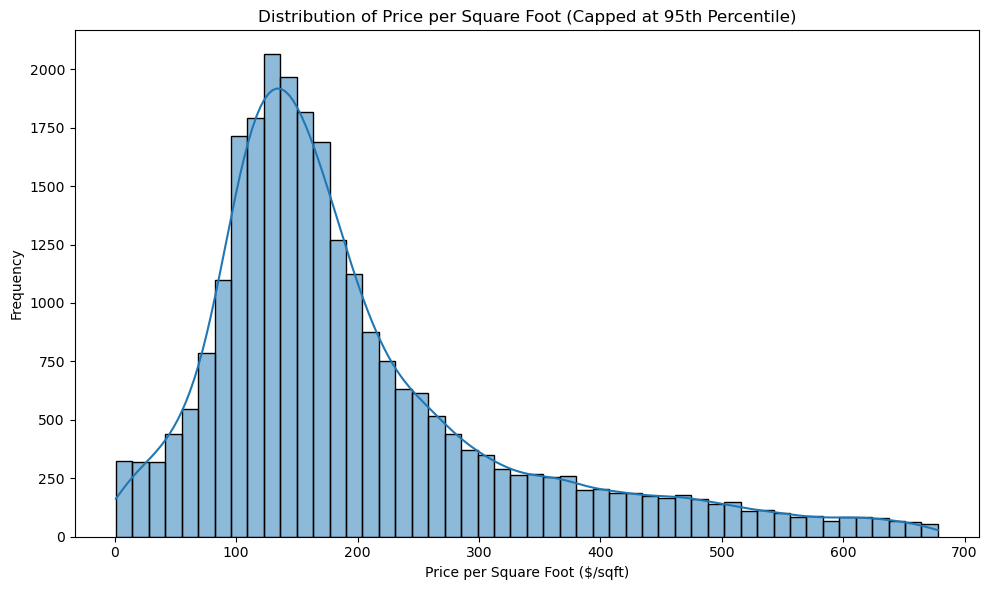

Generating word cloud for Address...


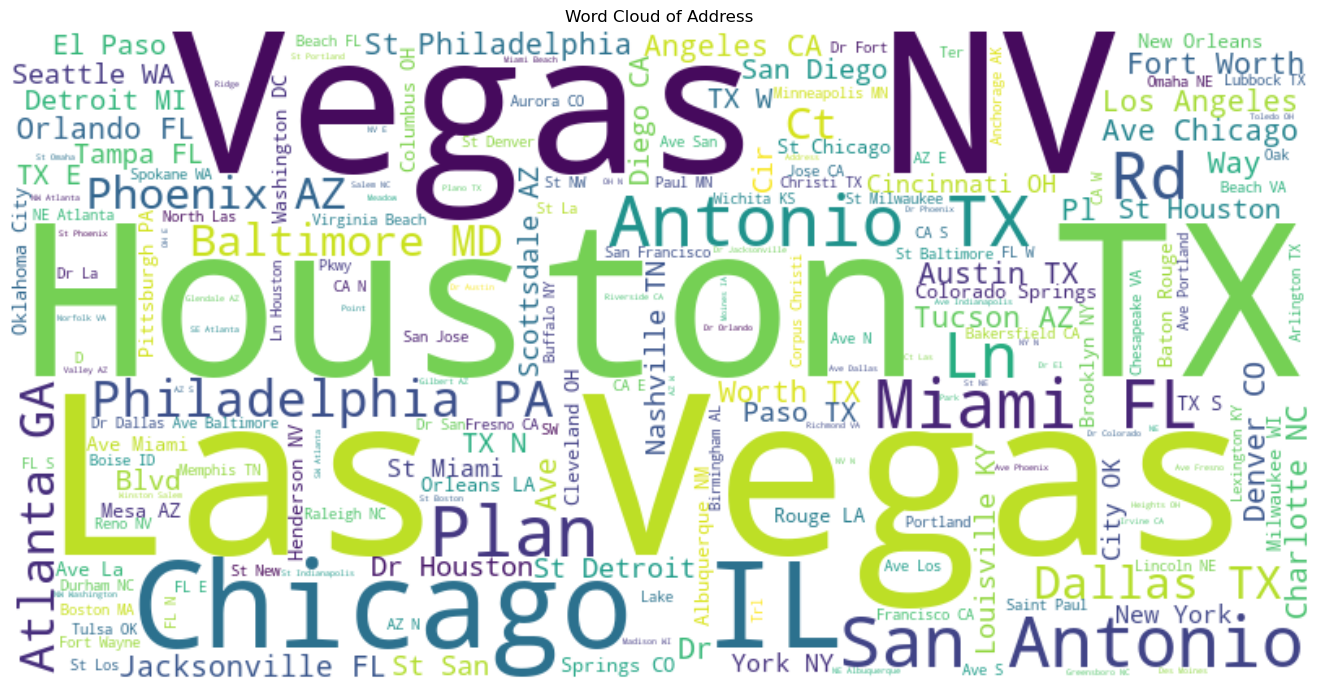

Generating word cloud for Address Full...


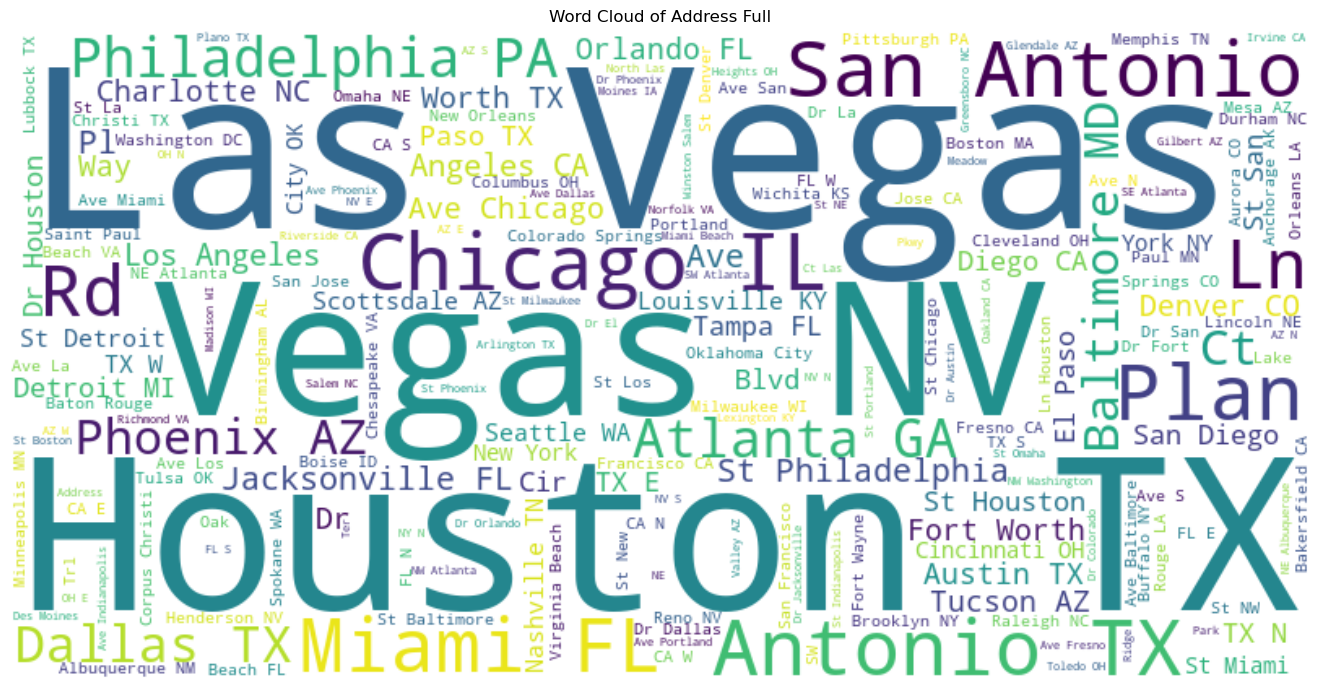

EDA completed successfully.


In [16]:
# Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from collections import Counter

# Import WordCloud if available
try:
    from wordcloud import WordCloud
except ImportError:
    WordCloud = None

# Advanced Exploratory Data Analysis Class
class ExploratoryDataAnalysis:
    def __init__(self, df):
        """
        Initialize the EDA with a DataFrame.

        Parameters:
        df (pd.DataFrame): The DataFrame to perform EDA on.
        """
        self.df = df.copy()
        self.numeric_features = ['Sqr Ft (sqft)', 'Beds', 'Bath', 'Lot Size (sqft)', 'Year Built']
        self.high_cardinality_cols = ['Price Sqr Ft ($/sqft)', 'Address', 'City', 'State', 'Address Full']
        self.categorical_cols = self.df.select_dtypes(include=['object']).columns.tolist()
        self.output_folder = "Visualisation Outputs/Advanced EDA Plots"
        os.makedirs(self.output_folder, exist_ok=True)

    def check_column_exists(self, column_name):
        """
        Check if a column exists in the DataFrame.

        Parameters:
        column_name (str): The name of the column to check.

        Returns:
        bool: True if the column exists, False otherwise.
        """
        if column_name not in self.df.columns:
            print(f"Error: '{column_name}' column not found in the dataframe.")
            return False
        return True

    def clean_data(self):
        """
        Clean the DataFrame for analysis.

        - Convert 'Price ($)' to numeric, handling 'Contact For Estimate'.
        - Convert 'Lot Size (sqft)' from acres to sqft if necessary.
        - Ensure all numeric features are converted to numeric data types.
        - Log transform 'Price ($)'.
        """
        print("Cleaning data...")
        # Clean 'Price ($)' column
        self.clean_price_column()

        # Clean 'Lot Size (sqft)' column
        self.clean_lot_size_column()

        # Convert numeric features to appropriate data types
        self.convert_numeric_features()

        # Log transform 'Price ($)'
        if self.check_column_exists('Price ($)'):
            self.df['Log Price ($)'] = np.log1p(self.df['Price ($)'])

    def clean_price_column(self):
        """Convert 'Price ($)' to numeric, handling special cases."""
        if self.check_column_exists('Price ($)'):
            self.df['Price ($)'] = self.df['Price ($)'].replace('Contact For Estimate', np.nan)
            self.df['Price ($)'] = pd.to_numeric(self.df['Price ($)'], errors='coerce')

    def clean_lot_size_column(self):
        """Clean and convert 'Lot Size (sqft)' to numeric values in sqft."""
        if self.check_column_exists('Lot Size (sqft)'):
            # Apply conversion to each value in 'Lot Size (sqft)'
            self.df['Lot Size (sqft)'] = self.df['Lot Size (sqft)'].apply(self.convert_lot_size)
            # Convert the cleaned values to numeric
            self.df['Lot Size (sqft)'] = pd.to_numeric(self.df['Lot Size (sqft)'], errors='coerce')

    def convert_numeric_features(self):
        """Ensure all specified numeric features are converted to numeric data types."""
        for feature in self.numeric_features:
            if self.check_column_exists(feature):
                self.df[feature] = pd.to_numeric(self.df[feature], errors='coerce')

    @staticmethod
    def convert_lot_size(value):
        """
        Convert 'Lot Size (sqft)' from acres to sqft if applicable.

        Parameters:
        value: The value to convert.

        Returns:
        float: The converted lot size in sqft, or NaN if conversion fails.
        """
        try:
            if pd.isna(value):
                return np.nan
            value_str = str(value).strip().lower()
            if 'acres' in value_str:
                # Extract the numeric part and convert acres to sqft
                number = float(value_str.replace('acres', '').strip())
                return number * 43560
            else:
                # Remove commas and convert to float
                return float(value_str.replace(',', ''))
        except (ValueError, TypeError):
            return np.nan

    def plot_categorical_boxplots(self):
        """
        Plot box plots for top categories in categorical variables.
        """
        print("Plotting box plots for categorical variables...")
        categorical_cols = [col for col in self.categorical_cols if col != 'Price ($)']
        for col in categorical_cols:
            if self.check_column_exists(col):
                # Get top 10 categories by frequency
                top_categories = self.df[col].value_counts().nlargest(10).index
                df_top = self.df[self.df[col].isin(top_categories)]
                if not df_top.empty:
                    plt.figure(figsize=(12, 6))
                    sns.boxplot(x=col, y='Price ($)', data=df_top)
                    plt.title(f'Price Distribution by Top 10 {col} Categories')
                    plt.xticks(rotation=45, ha='right')
                    plt.tight_layout()
                    filename = f'boxplot_{col}.png'.replace('/', '_').replace('\\', '_')
                    plt.savefig(os.path.join(self.output_folder, filename))
                    plt.show()  # Display the plot
                    plt.close()

    def handle_price_per_sqft(self):
        """
        Clean, transform, and plot 'Price Sqr Ft ($/sqft)' data.
        """
        col = 'Price Sqr Ft ($/sqft)'
        if self.check_column_exists(col):
            print("Handling 'Price Sqr Ft ($/sqft)'...")
            # Clean the data by removing trailing '/'
            self.df[col] = self.df[col].astype(str).str.replace('/', '', regex=False)
            # Convert to numeric
            self.df[col] = pd.to_numeric(self.df[col], errors='coerce')
            # Drop NaN values and filter out non-positive values
            df_clean = self.df.dropna(subset=[col]).copy()
            df_clean = df_clean[df_clean[col] > 0]
            if not df_clean.empty:
                # Cap outliers at the 95th percentile
                price_cap = df_clean[col].quantile(0.95)
                df_capped = df_clean[df_clean[col] <= price_cap].copy()
                # Apply logarithmic transformation
                df_capped.loc[:, 'Log Price Sqr Ft'] = np.log1p(df_capped[col])
                # Plot the log-transformed, capped distribution
                plt.figure(figsize=(10, 6))
                sns.histplot(df_capped['Log Price Sqr Ft'], bins=50, kde=True)
                plt.title('Log-Transformed Distribution of Price per Square Foot (Capped at 95th Percentile)')
                plt.xlabel('Log Price per Square Foot ($/sqft)')
                plt.ylabel('Frequency')
                plt.tight_layout()
                plt.savefig(os.path.join(self.output_folder, 'log_transformed_price_per_sqft.png'))
                plt.show()  # Display the plot
                plt.close()
                
                # Plot the original distribution (before log transformation)
                plt.figure(figsize=(10, 6))
                sns.histplot(df_capped[col], bins=50, kde=True)
                plt.title('Distribution of Price per Square Foot (Capped at 95th Percentile)')
                plt.xlabel('Price per Square Foot ($/sqft)')
                plt.ylabel('Frequency')
                plt.tight_layout()
                plt.savefig(os.path.join(self.output_folder, 'original_price_per_sqft.png'))
                plt.show()  # Display the plot
                plt.close()
            else:
                print("No valid data to plot for 'Price Sqr Ft ($/sqft)'.")

    def plot_wordclouds(self):
        """
        Generate word clouds for 'Address' and 'Address Full' columns, or plot top words.
        """
        for col in ['Address', 'Address Full']:
            if self.check_column_exists(col):
                print(f"Generating word cloud for {col}...")
                if WordCloud:
                    # Generate word cloud
                    text = ' '.join(self.df[col].dropna())
                    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
                    plt.figure(figsize=(15, 7))
                    plt.imshow(wordcloud, interpolation='bilinear')
                    plt.axis('off')
                    plt.title(f'Word Cloud of {col}')
                    plt.tight_layout()
                    filename = f'wordcloud_{col}.png'.replace('/', '_').replace('\\', '_')
                    plt.savefig(os.path.join(self.output_folder, filename))
                    plt.show()  # Display the plot
                    plt.close()
                else:
                    # Alternative visualization: Top 20 most common words
                    words = ' '.join(self.df[col].dropna()).split()
                    word_counts = Counter(words)
                    common_words = word_counts.most_common(20)
                    plt.figure(figsize=(12, 6))
                    sns.barplot(x=[word for word, _ in common_words], y=[count for _, count in common_words])
                    plt.title(f'Top 20 Most Common Words in {col}')
                    plt.xlabel('Words')
                    plt.ylabel('Count')
                    plt.xticks(rotation=45, ha='right')
                    plt.tight_layout()
                    filename = f'top_words_{col}.png'.replace('/', '_').replace('\\', '_')
                    plt.savefig(os.path.join(self.output_folder, filename))
                    plt.show()  # Display the plot
                    plt.close()

    def perform_eda(self):
        """
        Execute the complete EDA process:
        - Clean data
        - Plot box plots for categorical variables
        - Handle 'Price Sqr Ft ($/sqft)' column
        - Generate word clouds or top words for address columns
        """
        print("Starting EDA...")
        self.clean_data()
        print("Data cleaned successfully.")

        # Plot box plots for categorical variables
        self.plot_categorical_boxplots()

        # Handle 'Price Sqr Ft ($/sqft)'
        self.handle_price_per_sqft()

        # Generate word clouds or top words for address columns
        self.plot_wordclouds()

        print("EDA completed successfully.")

# Main execution
def main():
    file_path = "cleaned_data.csv"  # Update this path as needed

    if not os.path.exists(file_path):
        print(f"Error: The file '{file_path}' does not exist.")
    else:
        try:
            df = pd.read_csv(file_path)
            if df.empty:
                print("Error: The dataframe is empty. Unable to perform EDA.")
            else:
                print(f"Data loaded successfully. Shape: {df.shape}")
                eda = ExploratoryDataAnalysis(df)
                eda.perform_eda()
        except Exception as e:
            print(f"An error occurred during EDA: {str(e)}")

if __name__ == "__main__":
    main()


#### Model Price Prediction and Heteroscedasticity Handling

##### Note: This code is AI-generated as an experimental implementation of concepts learned beyond the class content.

This section implements a comprehensive approach to predict house prices while addressing potential heteroscedasticity issues. The code performs the following key steps:

1. Data Cleaning: Converts lot sizes, handles missing values, and ensures numeric data types.
2. Feature Engineering: Creates interaction terms and polynomial features to capture complex relationships.
3. Initial Model Fitting: Fits an Ordinary Least Squares (OLS) model and performs visual diagnostics.
4. Heteroscedasticity Testing: Uses Breusch-Pagan and White tests to detect heteroscedasticity.
5. Heteroscedasticity Handling: Applies Box-Cox or log transformations if heteroscedasticity is detected.
6. Model Refitting: Refits the model using transformed data or Weighted Least Squares if necessary.
7. Prediction and Evaluation: Generates predictions, inverts transformations if used, and calculates evaluation metrics.

The code adapts to the presence of heteroscedasticity, employing various statistical techniques to improve model reliability and prediction accuracy. However, it's noted in the Revision Notes.md file that there are still improvements that could be made for more complex projects and datasets. This implementation serves as a foundation, acknowledging that further refinements may be necessary for more sophisticated analyses.



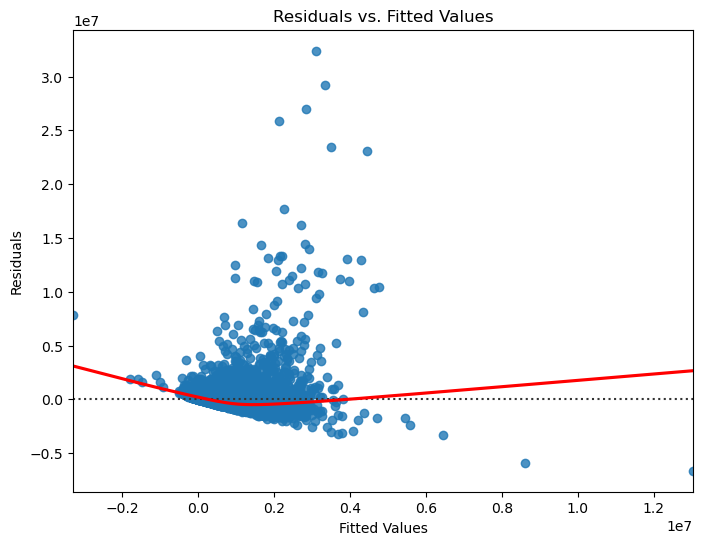

Breusch-Pagan p-value: 8.184009837555777e-150
White test p-value: nan
Heteroscedasticity detected. Applying transformations and robust methods.
Applied Box-Cox transformation with lambda: 0.08515525057791558
After Box-Cox transformation:
Breusch-Pagan p-value: 2.0296313024732756e-282
White test p-value: nan
Heteroscedasticity persists. Using Weighted Least Squares.
                            WLS Regression Results                            
Dep. Variable:              Price ($)   R-squared:                       0.851
Model:                            WLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                 1.794e+04
Date:                Sat, 05 Oct 2024   Prob (F-statistic):               0.00
Time:                        20:35:17   Log-Likelihood:            -3.0465e+05
No. Observations:               21983   AIC:                         6.093e+05
Df Residuals:                   21975   BIC:                         6.094e+05


C:\Users\22837352\AppData\Local\Temp\ipykernel_19152\3390780862.py:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df.index[valid_idx], 'Predicted Price'] = predictions


In [29]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from scipy import stats, special
import matplotlib.pyplot as plt
import seaborn as sns

# Note: AI-generated function to handle lot size conversion.
def convert_lot_size(value):
    """
    Convert 'Lot Size (sqft)' from acres to sqft if applicable.

    Parameters:
    value: The value to convert.

    Returns:
    float: The converted lot size in sqft, or NaN if conversion fails.
    """
    try:
        if pd.isna(value):
            return np.nan
        value_str = str(value).strip().lower()
        if 'acres' in value_str:
            # Extract the numeric part and convert acres to sqft
            number = float(value_str.replace('acres', '').strip())
            return number * 43560
        else:
            # Remove commas and convert to float
            return float(value_str.replace(',', ''))
    except (ValueError, TypeError):
        return np.nan

# Note: AI-generated function that addresses heteroscedasticity creatively.
def model_price_prediction(df):
    """
    Model the data to predict house prices, addressing heteroscedasticity creatively.

    Parameters:
    df: pandas DataFrame containing the relevant columns.

    Returns:
    pandas DataFrame: The original DataFrame with predicted prices added.
    """
    # Ensure required columns are present
    required_cols = ['Sqr Ft (sqft)', 'Beds', 'Bath', 'Lot Size (sqft)', 'Year Built', 'Price ($)']
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in the DataFrame.")

    # Data Cleaning
    # Clean 'Lot Size (sqft)' column
    df['Lot Size (sqft)'] = df['Lot Size (sqft)'].apply(convert_lot_size)
    # Convert to numeric
    df['Lot Size (sqft)'] = pd.to_numeric(df['Lot Size (sqft)'], errors='coerce')

    # Ensure other numeric columns are numeric
    numeric_cols = ['Sqr Ft (sqft)', 'Beds', 'Bath', 'Year Built', 'Price ($)']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Drop rows with missing values in required columns
    df = df.dropna(subset=required_cols)

    # Prepare features and target variable
    X = df[['Sqr Ft (sqft)', 'Beds', 'Bath', 'Lot Size (sqft)', 'Year Built']].copy()
    y = df['Price ($)'].copy()

    # Feature Engineering
    # Note: AI-generated feature engineering to include interaction and polynomial terms.
    X.loc[:, 'Beds_Bath'] = X['Beds'] * X['Bath']
    X.loc[:, 'Sqr Ft^2'] = X['Sqr Ft (sqft)'] ** 2
    X.loc[:, 'Age'] = 2023 - X['Year Built']

     # Note: AI-generated code to handle skewness in features.
    X.loc[:, 'Lot Size (sqft)'] = X['Lot Size (sqft)'].apply(lambda x: np.log1p(x) if x > 0 else 0)
    X.loc[:, 'Sqr Ft (sqft)'] = X['Sqr Ft (sqft)'].apply(lambda x: np.log1p(x) if x > 0 else 0)

    # Add constant term for intercept in the regression model
    X_const = sm.add_constant(X)

    # Note: AI-generated initial model fitting.
    model = sm.OLS(y, X_const).fit()

   # Note: AI-generated visual diagnostics to assess model quality.
    plt.figure(figsize=(8, 6))
    sns.residplot(x=model.fittedvalues, y=model.resid, lowess=True, line_kws={'color': 'red'})
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs. Fitted Values')
    plt.show()

    # Note: AI-generated heteroscedasticity test using Breusch-Pagan.
    bp_test = het_breuschpagan(model.resid, model.model.exog)
    bp_pvalue = bp_test[3]

    # Note: AI-generated heteroscedasticity test using White test.
    white_test = het_white(model.resid, model.model.exog)
    white_pvalue = white_test[3]

    print(f"Breusch-Pagan p-value: {bp_pvalue}")
    print(f"White test p-value: {white_pvalue}")

    used_transformation = False  # Flag to indicate if transformation was used

    # Note: AI-generated logic to determine if heteroscedasticity exists.
    if bp_pvalue < 0.05 or (white_pvalue is not None and white_pvalue < 0.05):
        print("Heteroscedasticity detected. Applying transformations and robust methods.")

        # Note: AI-generated Box-Cox transformation logic for heteroscedasticity.
        if (y <= 0).any():
            print("Cannot apply Box-Cox transformation due to non-positive target values.")
            y_transformed = np.log1p(y)
            transformation = 'Log'
        else:
            y_transformed, lambda_opt = stats.boxcox(y)
            print(f"Applied Box-Cox transformation with lambda: {lambda_opt}")
            transformation = 'Box-Cox'

        # Note: AI-generated refitting of the model after transformation.
        model_transformed = sm.OLS(y_transformed, X_const).fit()

        # Re-test for heteroscedasticity after transformation
        bp_test_transformed = het_breuschpagan(model_transformed.resid, model_transformed.model.exog)
        bp_pvalue_transformed = bp_test_transformed[3]
        white_test_transformed = het_white(model_transformed.resid, model_transformed.model.exog)
        white_pvalue_transformed = white_test_transformed[3]

        print(f"After {transformation} transformation:")
        print(f"Breusch-Pagan p-value: {bp_pvalue_transformed}")
        print(f"White test p-value: {white_pvalue_transformed}")

        if bp_pvalue_transformed >= 0.05 and (white_pvalue_transformed is None or white_pvalue_transformed >= 0.05):
            print("Heteroscedasticity resolved after transformation.")
            used_transformation = True  # Transformation was effective
            # Update the DataFrame with transformed target
            df['Transformed Price'] = y_transformed
            final_model = model_transformed
        else:
            print("Heteroscedasticity persists. Using Weighted Least Squares.")
            used_transformation = False  # Final model uses untransformed target
             # Note: AI-generated calculation of weights for Weighted Least Squares (WLS).
            weights = 1 / np.abs(model.resid)
            model_wls = sm.WLS(y, X_const, weights=weights).fit()
            final_model = model_wls
    else:
        print("No significant heteroscedasticity detected.")
        final_model = model

    # Display model summary for interpretation
    print(final_model.summary())

     # Note: AI-generated prediction and evaluation section.
    predictions = final_model.predict(X_const)

      # Note: AI-generated code for inverting transformation where applicable.
    if used_transformation:
        if transformation == 'Log':
            predictions = np.expm1(predictions)
        elif transformation == 'Box-Cox':
            # Inverse Box-Cox transformation
            predictions = special.inv_boxcox(predictions, lambda_opt)

    # Check for NaNs in predictions and handle them
    if np.isnan(predictions).any():
        print("Warning: Predictions contain NaN values. These will be dropped for evaluation.")
        # Remove NaNs from predictions and corresponding y values
        valid_idx = ~np.isnan(predictions)
        predictions = predictions[valid_idx]
        y = y.iloc[valid_idx]
    else:
        valid_idx = slice(None)  # All indices are valid

  # Note: AI-generated evaluation metrics calculation for model performance.
    from sklearn.metrics import mean_squared_error, r2_score
    mse = mean_squared_error(y, predictions)
    r2 = r2_score(y, predictions)
    print(f"\nModel Evaluation:")
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}")

    # Update the DataFrame with predictions
    df.loc[df.index[valid_idx], 'Predicted Price'] = predictions

    return df

# Apply the function to your DataFrame
if not df.empty:
    df = model_price_prediction(df)


##### Split Data into Training and Testing Sets
